In [11]:
import numpy as np
from random import getrandbits
from itertools import combinations
import copy
import pandas as pd
import pickle as pk
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit,QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import AerSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

from qiskit.circuit.library.standard_gates import (
    RXGate,
    RYGate,
    RXXGate,
    RYYGate,
    ZGate,
    XGate
)
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter

from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

In [12]:
from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import PauliTrotterEvolution, Suzuki
from qiskit.circuit import Parameter
from qiskit.opflow.primitive_ops.pauli_op import PauliOp

def two_paulis_rotation(theta: Parameter, pauliOp1: PauliOp, pauliOp2: PauliOp):
    if pauliOp1 not in [I, X, Y, Z]:
        raise Exception('pauliOp1 is not one of I, X, Y, or Z')
    if pauliOp2 not in [I, X, Y, Z]:
        raise Exception('pauliOp2 is not one of I, X, Y, or Z')

    H = 0.5 * (pauliOp2 ^ pauliOp1) # Qiskit uses "little endian" bit ordering
    evolution_op = (theta * H).exp_i() # exp(-iθH)

    trotterized_op = PauliTrotterEvolution(trotter_mode = Suzuki(order = 1)).convert(evolution_op)
    circuit = trotterized_op.to_circuit()
    return circuit.to_gate(label='Rxy')


def init_hadamard(circ : QuantumCircuit):
    qc = QuantumCircuit(circ.num_qubits)
    for n in range(qc.num_qubits):
        qc.h(n)
    qc += circ
    return qc

def findsubsets(k, n):
    return list(combinations(k, n))

def to_pauli(circ, maj_string):
    paulis = {
            (0, 0): np.matrix(np.eye(2)),
            (1, 0): np.matrix([[1, 0], [0, -1]]),
            (0, 1): np.matrix([[0, 1], [1, 0]]),
            (1, 1): np.matrix([[0, -1j], [1j, 0]]),
        }
    pauli = paulis[(maj_string[0], maj_string[circ.num_qubits])]

    for i in range(1, circ.num_qubits):
        pauli = np.kron(
            pauli, paulis[(maj_string[i], maj_string[i + circ.num_qubits])]
        )

    pauli = ((-1) ** maj_string[-1]) * pauli
    
    qc = QuantumCircuit(2)
    qc.unitary(pauli, [0, 1])
    return qc

def majorana_string(circ, i):
    return np.array(
        [1 if k < i // 2 else 0 for k in range(circ.num_qubits)]
        + [1 if k == (i - 1) // 2 else 0 for k in range(circ.num_qubits)]
        + [0]
        )

def majorana_product(circ, maj_list):
    if(len(maj_list)==0):
        return np.array([0] * 2 * circ.num_qubits)
    output = 0 * maj_list[0]
    for m in maj_list:
        parity = (maj_out[-1] + sum(maj_out[: circ.num_qubits] * maj[circ.num_qubits : -1]
                + maj[: circ.num_qubits] * maj_out[circ.num_qubits : -1]) % 2)
        output = (output + m) % 2
        output[-1] = parity
    return output

def x_state(circ, x, par):
    if par == 1:
        state = np.array([1, (-1) ** x[0]])
        for xx in x[1:]:
            state = np.kron(np.array([1, (-1) ** xx]), state)
        return state / (2 ** (circ.num_qubits / 2))
    elif par==0:
        state = np.array([1 + (-1) ** x[0], 1 - (-1) ** x[0]]) / 2
        for xx in x[1:]:
            state = np.kron(np.array([1 + (-1) ** xx, 1 - (-1) ** xx]) / 2, state)
        return state
        

def x_inps(circ, maj, par):
    return np.array(
            [(x_state(circ, x, par) @ maj @ (x_state(circ, x, par)).T.conj())[0, 0]
             for x in product([0, 1], repeat=circ.num_qubits)])

In [13]:
seed = np.random.randint(0, np.iinfo(np.int32).max)
rng = np.random.default_rng(seed)

In [69]:
def get_id():
    return getrandbits(32)
    
def add_random_xy(circ : QuantumCircuit, q0 : int, q1 : int):
    #theta = 4* np.pi * np.random()
    theta = rng.uniform(0, 4 * np.pi)
    xy = two_paulis_rotation(theta, X, Y)
    
    print(theta)
    print(theta)
    circ.append(xy, [q0, q1])
    circ.x(0)
    circ.append(xy, [q0, q1])
    circ.x(0)
    
    return circ

def add_random_Z(circ : QuantumCircuit, q0 : int):
    theta = rng.uniform(0, 4 * np.pi)
    
    circ.rz(theta, q0)
    
    return circ

def add_random_circ(circ : QuantumCircuit):
    for i in reversed(range(circ.num_qubits)):
        for k in [0, 1]:
            for j in range(i):
                circ = add_random_Z(circ, j)
                circ = add_random_xy(circ, j, j+1)
            if k == 0:
                circ = add_random_Z(circ, i)
    
    if getrandbits(1) == 1:
        circ.x(circ.num_qubits-1)
    
    return circ

def add_sequence(circ : QuantumCircuit, length : int):
    for i in range(length):
        circ = add_random_circ(circ)
    return circ

def measuring(circ : QuantumCircuit, basis):
    #backend = least_busy(provider.backends())
    if basis == "Z":
        circ.measure_all()
        return circ
    elif basis == "X":
        qc = QuantumCircuit(circ.num_qubits)
        for i in range(qc.num_qubits):
            qc.h(i)
        qc += circ
        qc.measure_all()
        return qc

In [70]:
def compute_wave_function(circ : QuantumCircuit):
    backend = Aer.get_backend('statevector_simulator')
    result = execute(circ, backend=backend).result()
    return result.get_statevector(circ)

def computer_correlator(circ : QuantumCircuit):
    wave = {0 : compute_wave_function(circ), 1: compute_wave_function(init_hadamard(circ))}
    
    correlator = {}
    for k in range(0, 2*circ.num_qubits+1):
        corr = np.array([0 * 1j] * (2 ** circ.num_qubits))
        for S in findsubsets(range(1, circ.num_qubits + 1), k):
            maj = to_pauli(circ,
                    majorana_product(circ, [majorana_string(circ, i) for i in S]))
            H = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]])
            
            inpt = (np.tensordot(wave[k % 2], np.tensordot(np.tensordot(maj, H), np.tensordot(wave[k % 2], H))))[0, 0]
            corr += inpt * x_inps(circ, maj, k%2)
            correlator[k] = corr
    return correlator
            

In [71]:
def make_noisy(circ, q0, p_probs):
    probs = [1 - sum(p_probs)] + p_probs
    qerror_0 = amplitude_damping_error(probs)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(qerror_0, 'X')
    noise_model.add_basis_gates(['X'])
    return noise_model

def experiment(circ, num_shots, p_probs=[0, 0, 0,]):
    freq = {"Z": [], "X": []}
    for basis in ["X", "Z"]:
        circ = measuring(circ, basis)
        if sum(p_probs) > 0:
            noise_model = make_noisy(circ, 0, p_probs)
            sim = AerSimulator(noise_model=noise_model)
            noise_circ = transpile(circ, sim)
        else:
            sim = AerSimulator()
            noise_circ = transpile(circ, sim)
    
        unique, counts = np.unique(
                np.array(
                    [str(x[0]) + str(x[1]) for x in sim.run(noise_circ).result().get_counts(0)]
                    + ["00", "01", "10", "11"]
                ),
                return_counts=True,
            )
        freq[basis] = np.real((counts - np.ones(len(counts)))) / num_shots
        print(freq[basis])
        print(sim.run(noise_circ).result().get_counts())
    return freq

In [72]:
circuit_length = list([2, 3, 4, 5, 6, 7, 8, 10, 12])
NUM_RAND_SEQUENCES = 4
random_circuit = [[] for k in range(NUM_RAND_SEQUENCES)] 
#{m: [add_random_circ(QuantumCircuit(2)) for i in range(NUM_RAND_SEQUENCES)] for m in circuit_length}
for k in range(NUM_RAND_SEQUENCES):
    for m in range(len(circuit_length)):
        random_circuit[k].append(add_random_circ(QuantumCircuit(2)))

2.64649082768947
2.64649082768947
3.2107293474636314
3.2107293474636314
9.613239536423453
9.613239536423453
10.048470882333136
10.048470882333136
11.641008795772935
11.641008795772935
12.1710247572469
12.1710247572469
8.342295001864162
8.342295001864162
7.3941519018064765
7.3941519018064765
11.11969055155817
11.11969055155817
11.717195597551774
11.717195597551774
3.355931233915422
3.355931233915422
3.9471013208617203
3.9471013208617203
6.2240312173892
6.2240312173892
5.838753716076118
5.838753716076118
6.292709292672784
6.292709292672784
6.8901022583704945
6.8901022583704945
11.453820123046754
11.453820123046754
5.700760636311943
5.700760636311943
7.908517707320758
7.908517707320758
5.545325162905001
5.545325162905001
9.94842331905045
9.94842331905045
5.950424876276442
5.950424876276442
4.120024429160988
4.120024429160988
1.4038501599263238
1.4038501599263238
2.6487972804819218
2.6487972804819218
9.683431157511132
9.683431157511132
8.779361341180625
8.779361341180625
6.731165039316027


In [73]:
num_shots = 1024

results = {m:{} for m in circuit_length}
correlators = np.array([])
for k in range(NUM_RAND_SEQUENCES):
    print("running {}".format(k))
    for m in range(len(circuit_length)):
        circ = add_sequence(random_circuit[k][m], circuit_length[m])
        correlators = np.append(correlators, computer_correlator(circ))
        results[circuit_length[m]][get_id()] = experiment(circ, num_shots)
        
#for k in range(NUM_RAND_SEQUENCES):
#    print("running {}".format(k))
#    for m in circuit_length:
#       ran = add_random_circ(

running 0
0.8088941687872725
0.8088941687872725
0.09748220426811112
0.09748220426811112
7.2432160137190245
7.2432160137190245
9.573248886781375
9.573248886781375
Traceback (most recent call last):
  Input In [73] in <cell line: 5>
    correlators = np.append(correlators, computer_correlator(circ))
  Input In [70] in computer_correlator
    inpt = (np.tensordot(wave[k % 2], np.tensordot(np.tensordot(maj, H), np.tensordot(wave[k % 2], H))))[0, 0]
  File <__array_function__ internals>:180 in tensordot
  File /opt/conda/lib/python3.8/site-packages/numpy/core/numeric.py:1110 in tensordot
    raise ValueError("shape-mismatch for sum")
ValueError: shape-mismatch for sum

Use %tb to get the full traceback.


/tmp/ipykernel_116/2363893961.py:24: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += circ


In [74]:
c_length = np.array(circuit_length)
print(c_length)
print([len(c_length[x]) for x in c_length])
for x in c_length:
    print(len(c_length[x]))

[ 2  3  4  5  6  7  8 10 12]
Traceback (most recent call last):
  Input In [74] in <cell line: 3>
    print([len(c_length[x]) for x in c_length])
  Input In [74] in <listcomp>
    print([len(c_length[x]) for x in c_length])
TypeError: object of type 'numpy.int64' has no len()

Use %tb to get the full traceback.


In [75]:
from scipy.optimize import curve_fit

In [76]:
#Normalization factors for each decay
normalisation = [1, 4, 4 / 3, 4, 1]

corr_data = {}
average = {}
variance = {}

for k in range(5):
    if k%2 == 0:
        basis = "Z"
    else:
        basis = "X"
    correlators = computer_correlator(
    corr_data[k] = np.real(
        [
            normalisation[k]
            * np.array(
                [
                    sum(computer_correlator(results[circuit_length[m]][get_id()] * results[circuit_length[m]][get_id()]))
                    for i in c_length
                ]
            )
            for m in c_length
        ]
    )

    average[k] = np.array(
        [np.mean(corr_data[k][m]) for m in range(len(sequence_lengths))]
    )

    variance[k] = np.array(
        [np.var(corr_data[k][m]) for m in range(len(sequence_lengths))]
    )

Traceback (most recent call last):
  File /opt/conda/lib/python3.8/site-packages/IPython/core/compilerop.py:105 in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  Input In [76]
    average[k] = np.array(
    ^
SyntaxError: invalid syntax

Use %tb to get the full traceback.


In [77]:
#Stores the extracted Majorana fidelities
poles = {}

#Stores the associated amplitudes
amplitudes = {}

#Starting points for curve_fit for each curve
inits = [[1, 1], [0.9, 1], [0.9, 1], [0.9, 1],[0.9, 1]]

#Fit an exponential to each curve, extracting pole and amplitude.
for k in range(5):
    for i in [0]:
        popt, pcov = curve_fit(
            exp, circuit_length, average[k], p0=inits1[k], maxfev=10000
        )
        poles[(i, k)] = popt[: i + 1]
        amplitudes[(i, k)] = popt[i + 1 :]



Traceback (most recent call last):
  Input In [77] in <cell line: 11>
    exp, circuit_length, average[k], p0=inits1[k], maxfev=10000
NameError: name 'exp' is not defined

Use %tb to get the full traceback.


Game

Hello, welcome to the prediction enchancement camp


Please state your name oli


Hi, oli


Do you wish to participate in the prediction enhancement camp? yes


Great, lets proceed!


How many qubits do you wish to use? 2
How many sequences do you wish to use? 3


Rxy rotations:
0.27896061074114
0.27896061074114
10.347539587758833
10.347539587758833
10.105846051939988
10.105846051939988
6.909620937821202
6.909620937821202
4.261147736672774
4.261147736672774
1.7110293868200832
1.7110293868200832
8.785733485263014
8.785733485263014
6.790238787976428
6.790238787976428


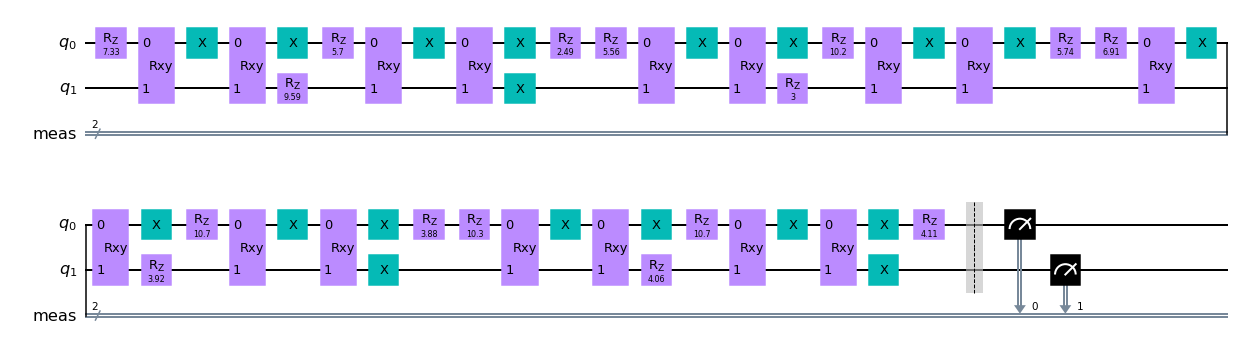

In [78]:
print("Hello, welcome to the prediction enchancement camp")
name = input("Please state your name")
print("Hi, " + name)
loop = True
while loop:
    answer = input("Do you wish to participate in the prediction enhancement camp?")
    if(answer.lower() == "yes"):
        loop = False
        print("Great, lets proceed!")
        qubits = input("How many qubits do you wish to use?")
        length = input("How many sequences do you wish to use?")
    elif(answer.lower() == "no"):
        print("Have a good day!")
        loop = False
    else:
        print("Sorry, I didn't get that") 
print("Rxy rotations:")
qc = QuantumCircuit(int(qubits))
qc = add_random_circ(qc)
qc = add_sequence(qc, int(length))
qc.measure_all()
qc.draw(output='mpl')

In [82]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
import itertools
lst = list(itertools.product([0, 1], repeat=qc.num_qubits))
print(counts)
print(lst)
print("What is the expected outcome? (1024 shots)")

arr = np.array([])
for k, v in counts.items():
    arr = np.append(arr, v)
for i in range(len(lst)):
    print(lst[i])
    ans = input("")
    if(int(ans) == arr[i]):
        print("Correct!")
    else:
        print("Wrong!")

{'10': 308, '01': 716}
[(0, 0), (0, 1), (1, 0), (1, 1)]
What is the expected outcome? (1024 shots)
(0, 0)


 0


Wrong!
(0, 1)


 716


Correct!
(1, 0)


 308


Traceback (most recent call last):
  Input In [82] in <cell line: 15>
    if(int(ans) == arr[i]):
IndexError: index 2 is out of bounds for axis 0 with size 2

Use %tb to get the full traceback.
